In [1]:
import Pkg
Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


In [2]:
using SnoopCompile, SnoopCompileCore, AbstractTrees

In [3]:
using JET

In [1]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads, Test

Precompiling packages...
  13097.1 ms  ✓ BackAction
  1 dependency successfully precompiled in 16 seconds. 285 already precompiled.


In [5]:
using BenchmarkTools

# Checking Step by Step

## Check the convergence to the average by direct evaluation of the observables

In [3]:
# Parameters and time evaluation
params = SimulParameters([1.0+0im; 0.0], #initial condition
    300.0, #tf
    1, # seed
    3_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
tspan = (0.0, params.tf)
t0, tf = tspan
nsaves = 100
saveat = collect(LinRange(t0, tf, nsaves));
ntimeseval = 2000
t_eval = collect(LinRange(t0, tf , ntimeseval))
gamma = 1.0
delta = 0.5
omega = 0.5

H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L = sqrt(gamma)*BackAction.sigma_m

sys = System(H, [L])
# Analytical solution
#
#sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
#u0 = zeros(Float64, 3)
#for k in 1:3
#    u0[k] = real(dot(params.psi0, sigma[k], params.psi0))
#end
#function resonance_fluorescene!(du, u, p, t)
#    du[1] = - 0.5*gamma*u[1] - delta*u[2]  
#    du[2] = + delta*u[1] - 0.5*gamma*u[2]- omega*u[3]  
#    du[3] = omega*u[2] - gamma*u[3] - gamma
#end
#prob_analytical = ODEProblem(resonance_fluorescene!, u0, tspan)
#sol_analytical = solve(prob_analytical, save_everystep=false);

System(NLEVELS=2
NCHANNELS=1
H=ComplexF64[-0.25 + 0.0im 0.25 + 0.0im; 0.25 + 0.0im 0.25 + 0.0im]
Ls=Matrix{ComplexF64}[[0.0 + 0.0im 1.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im]]
J=ComplexF64[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im])
Heff=ComplexF64[-0.25 + 0.0im 0.25 + 0.0im; 0.25 + 0.0im 0.25 - 0.5im])

In [17]:
@time sim = get_sol_jumps(sys, params, tspan; save_everystep=false);

  1.612436 seconds (5.08 M allocations: 487.200 MiB, 10.11% gc time)


In [ ]:
BackAction.states_atjumps(sim[1].prob[:callback].affect!.jump_times, sim[1].prob[:callback].affect!.jump_channels,
                        )

In [ ]:
(jumptimes::Vector{T1}, labels::Vector{T2}, sys::System,
    psi0::Vector{T3}; normalize::Bool=true) where {T1<:Real,T2<:Int,T3<:Complex}


In [6]:
# Obtain the observables
r_sample = Array{Float64}(undef, 3, ntimeseval, params.ntraj)
@threads for n in 1:params.ntraj
    for t in 1:ntimeseval
        for k in 1:3
            r_sample[k, t, n] = real(dot(sim[n](t_eval[t]), sigma[k], sim[n](t_eval[t])))/dot(sim[n](t_eval[t]), sim[n](t_eval[t]))
        end
    end
end

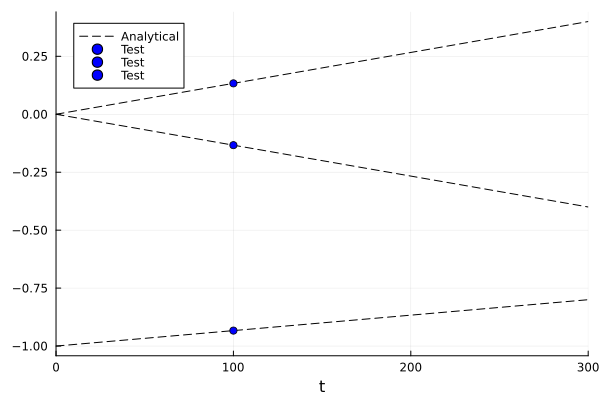

In [18]:
# Analytical
s = sol_analytical(100.0)
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash)
plot!(sol_analytical, idxs=(0,2), label=false, color="black", line=:dash)
plot!(sol_analytical, idxs=(0,1), label=false, color="black", line=:dash)
# Point test
scatter!([100.0], [s[1]] , label="Test", color="Blue")
scatter!([100.0], [s[2]] , label="Test", color="Blue")
scatter!([100.0], [s[3]] , label="Test", color="Blue")
# Sample
#plot!(t_eval, r_sample[1, :, end], label="sample", color="green")
#plot!(t_eval, r_sample[2, :, end], label=false, color="green")
#plot!(t_eval, r_sample[3, :, end], label=false, color="green")
## Average
#plot!(t_eval, dropdims(mean(r_sample[1, :, :], dims=2), dims=2), label="Average", color="red")
#plot!(t_eval, dropdims(mean(r_sample[3, :, :], dims=2), dims=2), label=false, color="red")
#plot!(t_eval, dropdims(mean(r_sample[2, :, :], dims=2), dims=2), label=false, color="red")

## Check convergence to the average by trajectory extraction 

In [ ]:
trajectories = Vector{Trajectory}(undef, params.ntraj)
for k in 1:params.ntraj
    trajectories[k] = extract_trajectory(sim[k])
end

In [ ]:
@testset "Resonance Fluorescene: Expectation Value Convergence" begin
    ntimes = length(t_eval)
    sample = zeros(ComplexF64,  sys.NLEVELS, ntimes, params.ntraj) # states

    for n in 1:params.ntraj
        states = BackAction.states_att(t_eval, trajectories[n], sys,  params.psi0)
        sample[:, :, n] = states[:, :]
    end
    # Obtain the value of the observables
    r_sample = zeros(Float64, ntimes, 3, params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]

    for j in 1:params.ntraj
        for k in 1:3
            for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[:, tn, j], sigma[k], sample[:, tn, j])   # Drop the extra dimension
            end
        end
    end
    r_avg = dropdims(mean(r_sample, dims=3), dims=3) # Ensemble average


    # System of equations for RF (Source: Wiseman section 3.3.1)
    function f_resonancefluorescene(t, r)
        return [-0.5*gamma*r[1] - 2*delta*r[2]; 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3];
                2*omega*r[2] - gamma*(r[3] + 1)]
    end

    for k in 1:ntimes
        @test abs(sol_analytical(t_eval[k])[1] - r_avg[k, 1]) < 0.1
        @test abs(sol_analytical(t_eval[k])[2] - r_avg[k, 2]) < 0.1
        @test abs(sol_analytical(t_eval[k])[3] - r_avg[k, 3]) < 0.1
    end
end



# Checking FI

In [15]:
# Trajectory extraction
"From the solution, obtain the trajectory"
function extract_trajectory(sol::ODESolution)
    times = sol.prob.kwargs[:callback].affect!.jump_times
    channels = sol.prob.kwargs[:callback].affect!.jump_channels
    njumps = length(times)
    traj = Vector{DetectionClick}(undef, njumps)
    traj[1] = DetectionClick(times[1], channels[1]) 
    @inbounds for k in 2:njumps   
       traj[k] = DetectionClick(times[k] - times[k-1], channels[k]) 
    end  
    return traj
end

extract_trajectory

In [9]:
# Set up the unravelings
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end
function get_random_unraveling(seed)
    Random.seed!(seed)
    T = sample_c2(seed) 
    T = reshape(T/norm(T), 2,1)
    T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
    F = svd(T_curvy) # Factorization object
    P = F.V * Diagonal(F.S) * F.Vt
    O = F.U * F.Vt
    T_curvy_dyne = O' * T_curvy
    T_dyne = O' * real.(T) + 1im * O' * imag.(T)
    Ta = T 
    Tb = T_dyne 
    Tc = T_dyne 
    Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
    alpha0 = [0.5 + 0im; 0.5 + 0im] 
    alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas

    return Ts, alphas
end


get_random_unraveling (generic function with 1 method)

In [7]:
Ts = [1.0 + 0im]
alphas = collect(LinRange(0.0, 2.0, 30));

In [4]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
                                1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]
fi_t_gammelmark = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494,
                   0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348];

In [2]:
# Base parametric operators
H0 = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*BackAction.sigma_x
L0 = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*BackAction.sigma_m
# Unraveling parametrix operators
function obtain_parametric_unraveling_operators(T, alpha)
    nchannels, jmax = size(T)
    njumps_original = 1 #number of original jump
    Ls_new = [(delta, omega, k) -> (sum(T[i, j] * L0(delta, omega, k) for j in 1:njumps_original) + alpha[i]*I) for i in 1:nchannels]
    J = (delta, omega, k) -> sum(conj(alpha[i])*Ls_new[i](delta, omega, k)-alpha[i]*adjoint(Ls_new[i](delta, omega, k)) for i in 1:nchannels)
    H = (delta, omega, k) -> H0(delta, omega, k) - 0.5im * J(delta, omega, k)
                               
    He = BackAction.getheff_parametrized(H, Ls_new)
    return Ls_new, H, He
end


obtain_parametric_unraveling_operators (generic function with 1 method)

In [5]:
J0 = BackAction.He

BackAction.SumProductJumpOperators{var"#3#4"}([var"#3#4"()])

In [8]:
J0(0.0, 0.0, 2.0)

2×2 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im
 0.0+0.0im  2.0+0.0im

In [10]:
using JET

In [12]:
function GetFI( params::SimulParameters{T1, T2, T3},  fi_samples::Array{T2}, delta::T2, omega::T2=1.0, k::T2=0.5;
        T::Matrix{T1} = reshape([1.0 + 0im], 1,1),
        alpha::Vector{T1} = [0.0 + 0im])::Tuple{T2, T2} where {T1<:Complex, T2<:Real, T3<:Int}
# System and parameters
    Ls, H, He = obtain_parametric_unraveling_operators(T, alpha)
    sys = System(H(delta, omega, k), # Hamiltonian
                 [L(delta, omega, k) for L in Ls], # jump
                )
    sim = get_sol_jumps(sys, params,  (0.0, params.tf); save_on=false);
    # Process the jumptimes to put it in terms of increments rather than absolute times
    for n in 1:params.ntraj
        for i in 0:length(sim[n].prob.kwargs[:callback].affect!.jump_times)-2
                sim[n].prob.kwargs[:callback].affect!.jump_times[end - i] = sim[n].prob.kwargs[:callback].affect!.jump_times[end-i] - sim[n].prob.kwargs[:callback].affect!.jump_times[end-i-1]
        end
    end
    
     @threads for n in 1:params.ntraj
       
       fi_sample[n] = real(tr(monitoringoperator([tf], sys, He, Ls,
                                                    sim[n].prob.kwargs[:callback].affect!.jump_times,
                                                    sim[n].prob.kwargs[:callback].affect!.jump_channels,
                                                   params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0]))^2)/params.tf
    end
    return mean(fi_sample), std(fi_sample)
end

GetFI (generic function with 3 methods)

In [11]:
using Profile, ProfileView

In [15]:
@code_warntype He(0.0, 0.0, 0.0)

MethodInstance for (::BackAction.var"#45#47"{var"#26#32"{var"#24#30"{Vector{ComplexF64}, Vector{var"#22#28"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, Int64}}, Vector{var"#22#28"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}})(::Float64, ::Float64, ::Float64)
  from (::BackAction.var"#45#47")(theta...) @ BackAction ~/Documents/Research/MonitoringMetrology/BackAction.jl/src/monitoring.jl:18
Arguments
  #self#::BackAction.var"#45#47"{var"#26#32"{var"#24#30"{Vector{ComplexF64}, Vector{var"#22#28"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, Int64}}, Vector{var"#22#28"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}}
  theta::Tuple{Float64, Float64, Float64}
Locals
  #46::BackAction.var"#46#48"{Tuple{Float64, Float64, Float64}}
  LLs_par::Vector
Body::Any
1 ─ %1  = BackAction.:(var"#46#48")::Core.Const(BackAction.var"#46#48")
│   %2  = Core.typeof(theta)::Core.Const(Tuple{Float64, Float64, Float64})
│   %3  = Core.apply_type(%1, %2)::Core.Const(BackA

In [19]:
@code_warntype BackAction.getheff_parametrized(H0, [L0])(0.0,0.0,0.0)

MethodInstance for (::BackAction.var"#45#47"{var"#17#18", Vector{var"#19#20"}})(::Float64, ::Float64, ::Float64)
  from (::BackAction.var"#45#47")(theta...) @ BackAction ~/Documents/Research/MonitoringMetrology/BackAction.jl/src/monitoring.jl:18
Arguments
  #self#::BackAction.var"#45#47"{var"#17#18", Vector{var"#19#20"}}
  theta::Tuple{Float64, Float64, Float64}
Locals
  #46::BackAction.var"#46#48"{Tuple{Float64, Float64, Float64}}
  LLs_par::Vector{Matrix{ComplexF64}}
Body::Matrix{ComplexF64}
1 ─ %1  = BackAction.:(var"#46#48")::Core.Const(BackAction.var"#46#48")
│   %2  = Core.typeof(theta)::Core.Const(Tuple{Float64, Float64, Float64})
│   %3  = Core.apply_type(%1, %2)::Core.Const(BackAction.var"#46#48"{Tuple{Float64, Float64, Float64}})
│         (#46 = %new(%3, theta))
│   %5  = #46::BackAction.var"#46#48"{Tuple{Float64, Float64, Float64}}
│   %6  = Core.getfield(#self#, :Ls_par)::Vector{var"#19#20"}
│   %7  = Base.Generator(%5, %6)::Base.Generator{Vector{var"#19#20"}, BackAction.v

In [26]:
He_test = BackAction.getheff_parametrized(H0, [L0])
@report_opt He_test(theta[1], theta[2], theta[3])

No errors detected


In [29]:
@code_warntype BackAction.expheff_derivative(He_test, tau, theta, dtheta)

MethodInstance for BackAction.expheff_derivative(::BackAction.var"#45#47"{var"#17#18", Vector{var"#19#20"}}, ::Float64, ::Vector{Float64}, ::Vector{Float64})
  from expheff_derivative(Heff_par::Tf, tau::T2, theta::Vector{T2}, dtheta::Vector{T2}) where {T2<:Real, Tf<:Function} @ BackAction ~/Documents/Research/MonitoringMetrology/BackAction.jl/src/monitoring.jl:50
Static Parameters
  T2 = Float64
  Tf = BackAction.var"#45#47"{var"#17#18", Vector{var"#19#20"}}
Arguments
  #self#::Core.Const(BackAction.expheff_derivative)
  Heff_par::BackAction.var"#45#47"{var"#17#18", Vector{var"#19#20"}}
  tau::Float64
  theta::Vector{Float64}
  dtheta::Vector{Float64}
Locals
  norm_dtheta::Float64
  aux1::ComplexF64
Body::Union{}
1 ─ %1 = (-1 * BackAction.im)::Core.Const(0 - 1im)
│        (aux1 = %1 * tau)
│        (norm_dtheta = BackAction.norm(dtheta))
│        aux1
│   %5 = (2 * dtheta)::Vector{Float64}
│   %6 = (theta + %5)::Vector{Float64}
│        Core._apply_iterate(Base.iterate, Heff_par, %6)
C

In [31]:
tau = 0.1
theta = [delta_gammelmark[1], 1.0, 0.5]
dtheta = [delta_gammelmark[1]/100, 0.0, 0.0]
Ls, H, He = obtain_parametric_unraveling_operators(reshape([1.0 + 0im], 1,1), [alphas[1]+0im])
@report_opt BackAction.expheff_derivative(He, tau, theta, dtheta)

[ Info: tracking Base
┌ Warning: Tuple{BackAction.var"#50#52", Any} was not found
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:1181


═════ 21 possible errors found ═════
┌ expheff_derivative(Heff_par::BackAction.var"#49#51"{…}, tau::Float64, theta::Vector{…}, dtheta::Vector{…}) @ BackAction /home/ste1nb0ck/Documents/Research/MonitoringMetrology/BackAction.jl/src/monitoring.jl:53
│┌ (::BackAction.var"#49#51"{var"#26#32"{var"#24#30"{…}}, Vector{var"#22#28"{…}}})(theta::Vararg{Float64}) @ BackAction /home/ste1nb0ck/Documents/Research/MonitoringMetrology/BackAction.jl/src/monitoring.jl:20
││┌ collect(itr::Base.Generator{Vector{var"#22#28"{…}}, F} where F<:(BackAction.var"#50#52"{Tuple{Vararg{…}}} where N)) @ Base ./array.jl:811
│││┌ promote_typejoin_union(::Type) @ Base ./promotion.jl:188
││││┌ promote_typejoin(a::Type, b::Type) @ Base ./promotion.jl:172
│││││┌ typejoin(a::Type, b::Type) @ Base ./promotion.jl:34
││││││┌ typejoin(a::Any, b::Type) @ Base ./promotion.jl:36
│││││││┌ typejoin(a::Any, b::Any) @ Base ./promotion.jl:127
││││││││ runtime dispatch detected: Base.UnionAll(%403::Any, %405::Any)::Any
│││││││└───────

In [16]:
tf = 300.0
ntraj = 100
params = SimulParameters(BackAction.rf_psi0,
                            tf, # Final time. Set very long so that all trajectories jump
                            1, # seed
                            ntraj, # Number of trajectories
                            30_000, # Number of samples in the finegrid
                            1.0, # Multiplier to use in the fine grid
                            1e-3 # Tolerance for passing Dark state test
                            )
NLEVELS = 2
ntimes = 1
fi_sample = Array{Float64}(undef, params.ntraj)

ndeltas = length(delta_gammelmark)
myfis_gammelmarkdeltas = zeros(Float64, ndeltas)
myfis_gammelmarkdeltas_stds = zeros(Float64, ndeltas)
@profview myfis_gammelmarkdeltas[1], myfis_gammelmarkdeltas_stds[1] = GetFI(params, fi_sample, delta_gammelmark[1])
#@time begin
#    for n in 1:ndeltas
#         myfis_gammelmarkdeltas[n], myfis_gammelmarkdeltas_stds[n] = GetFI(params, fi_sample, delta_gammelmark[n])
#    end 
#end 

Gsk-Message: 18:43:46.128: Failed to realize renderer of type 'GskNglRenderer' for surface 'GdkWaylandToplevel': Failed to create EGL display

Gsk-Message: 18:43:46.128: Failed to realize renderer of type 'GskGLRenderer' for surface 'GdkWaylandToplevel': Failed to create EGL display



Gtk4.GtkWindowLeaf(accessible-role=GTK_ACCESSIBLE_ROLE_APPLICATION, name="", parent, root, width-request=-1, height-request=-1, visible=true, sensitive=true, can-focus=true, has-focus=false, can-target=true, focus-on-click=true, focusable=false, has-default=false, receives-default=false, cursor, has-tooltip=false, tooltip-markup=nothing, tooltip-text=nothing, opacity=1.000000, overflow=GTK_OVERFLOW_HIDDEN, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, hexpand=false, vexpand=false, hexpand-set=false, vexpand-set=false, scale-factor=1, css-name="window", css-classes, layout-manager, title="Profile  -  18:43:44", resizable=true, modal=false, default-width=800, default-height=600, destroy-with-parent=false, hide-on-close=false, icon-name=nothing, display, decorated=true, deletable=true, transient-for, application, default-widget, focus-widget, child, titlebar, handle-menubar-accel=true, is-active=false, suspended=false, startup-i

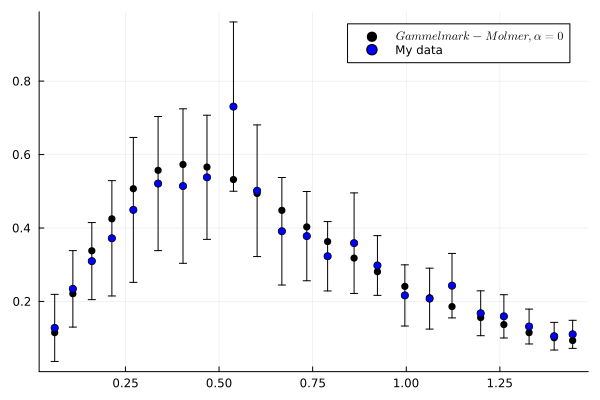

In [17]:
scatter(delta_gammelmark, fi_t_gammelmark, color = "black", label=L"Gammelmark-Molmer, \alpha=0")
scatter!(delta_gammelmark, myfis_gammelmarkdeltas, yerr = 2.576*myfis_gammelmarkdeltas_stds./sqrt(params.ntraj),color="blue", label="My data")

In [48]:
tf = 300.0
ntraj = 100
params = SimulParameters(BackAction.rf_psi0,
                            tf, # Final time. Set very long so that all trajectories jump
                            1, # seed
                            ntraj, # Number of trajectories
                            30_000, # Number of samples in the finegrid
                            1.0, # Multiplier to use in the fine grid
                            1e-3 # Tolerance for passing Dark state test
                            )
NLEVELS = 2
ntimes = 1
fi_sample = Array{Float64}(undef, params.ntraj)

In [52]:
nalphas = length(alphas)
fis = Array{Float64}(undef, nalphas, 3);
stds = Array{Float64}(undef, nalphas, 3);
fi_sample = Array{Float64}(undef, params.ntraj);


In [58]:
for d in 1:3
    println("alpha=$d")
        for k in 1:nalphas
           @time begin 
            fis[k, d], stds[k, d] = GetFI(params, fi_sample, delta_gammelmark[4*d]; alpha = [alphas[k] .+ 0.0im])
            end 
        end
end

alpha=1


LoadError: TaskFailedException

[91m    nested task error: [39mMethodError: no method matching tr(::Array{ComplexF64, 3})
    
    [0mClosest candidates are:
    [0m  tr([91m::Matrix{T}[39m) where T
    [0m[90m   @[39m [36mLinearAlgebra[39m [90m~/julia/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mdense.jl:344[24m[39m
    [0m  tr([91m::Symmetric{var"#s997", S} where {var"#s997"<:Number, S<:(AbstractMatrix{<:var"#s997"})}[39m)
    [0m[90m   @[39m [36mLinearAlgebra[39m [90m~/julia/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4msymmetric.jl:400[24m[39m
    [0m  tr([91m::UpperTriangular[39m)
    [0m[90m   @[39m [36mLinearAlgebra[39m [90m~/julia/share/julia/stdlib/v1.10/LinearAlgebra/src/[39m[90m[4mtriangular.jl:442[24m[39m
    [0m  ...
    
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[56]:18[24m[39m[90m [inlined][39m
     [2] [0m[1m(::var"#588#threadsfor_fun#114"{var"#588#threadsfor_fun#112#115"{SimulParameters{ComplexF64, Float64, Int64}, Float64, Float64, Float64, EnsembleSolution{ComplexF64, 3, Vector{ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, SciMLBase.NullParameters, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System{ComplexF64, Int64}, Nothing, Nothing}, @Kwargs{callback::ContinuousCallback{BackAction.var"#condition#24"{BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}}, BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}, BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Nothing, Int64}, save_on::Bool}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System{ComplexF64, Int64}, Nothing, Nothing}, Vector{Vector{ComplexF64}}, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, OrdinaryDiffEqTsit5.Tsit5Cache{Vector{ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing, Nothing}}}, System{ComplexF64, Int64}, BackAction.var"#37#39"{var"#28#34"{var"#26#32"{Vector{ComplexF64}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, Int64}}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [3] [0m[1m#588#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{var"#588#threadsfor_fun#114"{var"#588#threadsfor_fun#112#115"{SimulParameters{ComplexF64, Float64, Int64}, Float64, Float64, Float64, EnsembleSolution{ComplexF64, 3, Vector{ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, SciMLBase.NullParameters, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System{ComplexF64, Int64}, Nothing, Nothing}, @Kwargs{callback::ContinuousCallback{BackAction.var"#condition#24"{BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}}, BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}, BackAction._LindbladJump{ComplexF64, Float64, Xoshiro, Base.RefValue{Float64}, Int64, Base.RefValue{Int64}}, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Nothing, Int64}, save_on::Bool}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ComplexF64}, Vector{ComplexF64}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{ComplexF64}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, Vector{Complex{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}, SciMLBase.NullParameters, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, ComplexF64}, ComplexF64, 1}}}}, false}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System{ComplexF64, Int64}, Nothing, Nothing}, Vector{Vector{ComplexF64}}, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, OrdinaryDiffEqTsit5.Tsit5Cache{Vector{ComplexF64}, Vector{ComplexF64}, Vector{ComplexF64}, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing, Nothing}}}, System{ComplexF64, Int64}, BackAction.var"#37#39"{var"#28#34"{var"#26#32"{Vector{ComplexF64}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, Int64}}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}}, Vector{var"#24#30"{Int64, Matrix{ComplexF64}, Vector{ComplexF64}, Int64}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

...and 3 more exceptions.


In [9]:
y_bound = [ 0.5549738219895288 ,0.5445026178010471 ,0.5916230366492147 ,0.6282722513089005 ,0.675392670157068
    ,0.7382198952879582 ,0.8272251308900525 ,0.8638743455497383 ,0.8848167539267017 ,0.8481675392670157 ,0.7958115183246074 ,
    0.7277486910994765 ,0.6701570680628273 ,0.5916230366492147 ,0.5287958115183247 ,0.47643979057591623 ,0.4136125654450262 ,
    0.3717277486910995 ,0.3089005235602094 ,0.2879581151832461 ,0.25654450261780104 ,0.22513089005235604 ,0.193717277486911 ,0.18848167539267016]

x_bound = [0.06282051282051282, 0.022435897435897433,0.10096153846153845, 0.13685897435897434, 0.175, 0.675392670157068,
0.22435897435897434, 
0.30288461538461536, 
0.35, 0.8638743455497383,
0.4330128205128205,
0.5541666666666666,
0.6192307692307691,
0.6887820512820513,
0.7471153846153845,
0.8233974358974359,
0.8839743589743589,
0.9423076923076923,
1.014102564102564, 
1.0612179487179487,
1.1509615384615384,
1.2048076923076922,
1.251923076923077, 
1.3192307692307692,
1.3798076923076923,
1.433653846153846]

26-element Vector{Float64}:
 0.06282051282051282
 0.022435897435897433
 0.10096153846153845
 0.13685897435897434
 0.175
 0.675392670157068
 0.22435897435897434
 0.30288461538461536
 0.35
 0.8638743455497383
 0.4330128205128205
 0.5541666666666666
 0.6192307692307691
 0.6887820512820513
 0.7471153846153845
 0.8233974358974359
 0.8839743589743589
 0.9423076923076923
 1.014102564102564
 1.0612179487179487
 1.1509615384615384
 1.2048076923076922
 1.251923076923077
 1.3192307692307692
 1.3798076923076923
 1.433653846153846

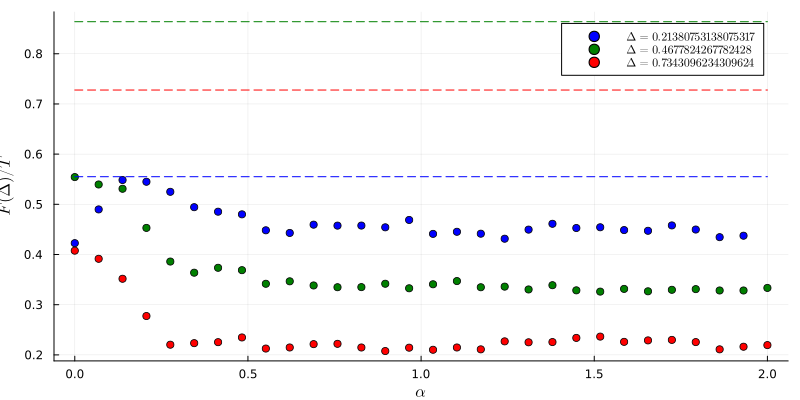

In [10]:
scatter(alphas, fis[:, 1], color="blue", label=L"\Delta=%$(delta_gammelmark[4])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")
scatter!(alphas, fis[:, 2], color="green", label=L"\Delta=%$(delta_gammelmark[4*2])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")
scatter!(alphas, fis[:, 3], color="red", label=L"\Delta=%$(delta_gammelmark[4*3])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")

plot!([alphas[1], alphas[end]], [y_bound[1], y_bound[1]], label=false, color="blue", line=:dash)
plot!([alphas[1], alphas[end]], [y_bound[4*2], y_bound[4*2]], label=false, color="green", line=:dash)
plot!([alphas[1], alphas[end]], [y_bound[4*3], y_bound[4*3]], label=false, color="red", line=:dash, size=(800, 400), legend=:topright)

#scatter!(delta_gammelmark, stepbystepfi_0, label=L"\alpha=0", color="blue", )
#scatter!(delta_gammelmark, stepbystepfi_a, label=L"T_a", color="green", )
#scatter!(delta_gammelmark, stepbystepfi_b, label=L"T_b", color="red", )
#scatter!(delta_gammelmark, stepbystepfi_c, label=L"T_c", color="yellow", title="Fisher Information, T=300", xlabel="t", ylabel=L"F(\Delta) / T")